In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
import scipy.stats as ss

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def distance(data):
    distances = pd.DataFrame()    
    # calculate distance in km between points
    data['dx'] = np.insert(sw.distance(data['Lon'].values, data['Lat'].values, 0),0,0)/1000
    data['x'] = np.cumsum(data['dx'])

    return data  

def bin(pgram, periods, bins, bin_mid):
    
    y = periods
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)
    binned['k_mid'] = bin_mid
          
    z = pgram # bead attribute

    digitized = np.digitize(y, bins)
    bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

    bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
    bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]
        
    binned['var'] = bin_means
    binned['std'] = bin_std

    return binned


In [3]:
# import data

maxlon = 151
minlon = 139

Tok1 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)
Tok1 = distance(Tok1)
Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)].dropna()

Tok3 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo3_vSept16.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)
Tok3 = distance(Tok3)
Tok3 = Tok3[(Tok3['Lon']>minlon+5) & (Tok3['Lon']<maxlon+5)].dropna()

Tian = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)
Tian = distance(Tian)
Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)].dropna()

print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density', u'dx', u'x'],
      dtype='object')


number of segments =  3
estimated slope for NCP =  -2.0447590483 , r =  -0.877927333746 , p-value =  4.12136981163e-33
estimated slope for T =  -2.36486196355 , r =  -0.904217795681 , p-value =  5.45824990757e-38


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


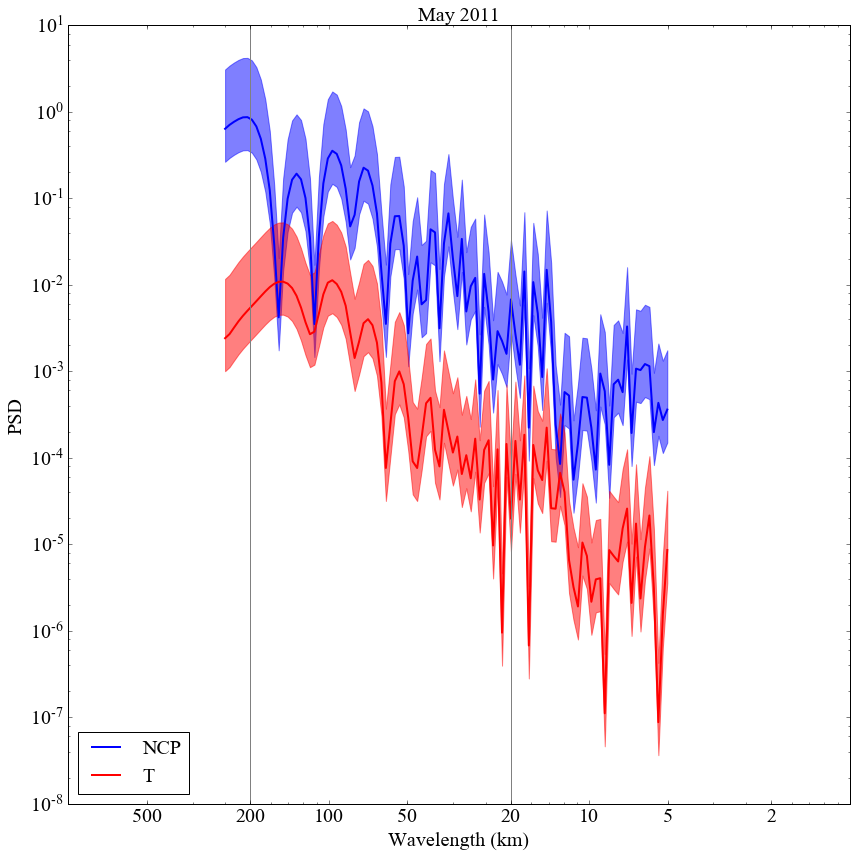

In [4]:
# Lomb-Scargle periodogram

M = 500;

nout = 100 # number of frequency-space points at which to calculate the signal strength (output)
periods = 10**(np.linspace(0.7, np.log10(M/2), nout))
freqs = 1.0 / periods
angular_freqs = 2 * np.pi * freqs

# for Tokyo_1 cruise
N = np.max(Tok1['x'].values) - np.min(Tok1['x'].values)


Tok1['nx'] = Tok1['x'] - np.min(Tok1['x'].values)

for n in range(np.int(N/M)):
    data = Tok1[(Tok1['nx']>n*M) & (Tok1['nx']<M*(n+1))]
    pgram =+ lombscargle(data['x'].values, (data['Air-sea flux'].values-data['Air-sea flux'].mean())*np.hanning(len(data)), angular_freqs)
    pgramT =+ lombscargle(data['x'].values, (data['T'].values-data['T'].mean())*np.hanning(len(data)), angular_freqs)

pgram = pgram/N
pgramT = pgramT/N

nu = 2*(np.int(N/M))
err_high = nu/ss.chi2.ppf(0.05/2, nu)
err_low = nu/ss.chi2.ppf(1-0.05/2, nu)


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)

plt.plot(1/periods, pgram, 'b', lw=2, label='NCP')
plt.fill_between(1/periods, pgram*err_low, pgram*err_high, color='blue', alpha = 0.5)

plt.plot(1/periods, pgramT, 'r', lw=2, label='T')
plt.fill_between(1/periods, pgramT*err_low, pgramT*err_high, color='red', alpha = 0.5)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.yscale('log')
plt.xscale('log')


plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavelength (km)', fontsize = 20)
plt.xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

plt.axvline(1./200, color = 'grey')
plt.axvline(1./20, color = 'grey')


plt.title('May 2011',fontsize = 20)

print 'number of segments = ',np.int(N/M)

A = np.vstack([np.log10(1./periods), np.ones(len(periods))]).T

#m, c = np.linalg.lstsq(A, np.log10(pgram))[0]
m,c, r, p, std_err = ss.linregress(np.log10(1./periods),np.log10(pgram))

#mT, c = np.linalg.lstsq(A, np.log10(pgramT))[0]
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(1./periods),np.log10(pgramT))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value = ', p
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value = ', pT

#plt.loglog(1./periods, ((1./periods)**mT)/50000000, 'r')
#plt.loglog(1./periods, ((1./periods)**m)/500000, 'b')
plt.show()

#fig1.savefig('../figures/NCP_T_spectra_May11.png', bbox_inches='tight', dpi=600)

number of segments =  2
estimated slope for NCP =  -0.816226112455 , r =  -0.615142929682 , p-value =  9.80361114028e-12
estimated slope for T =  -1.67308189647 , r =  -0.846983920956 , p-value =  1.21466973762e-28


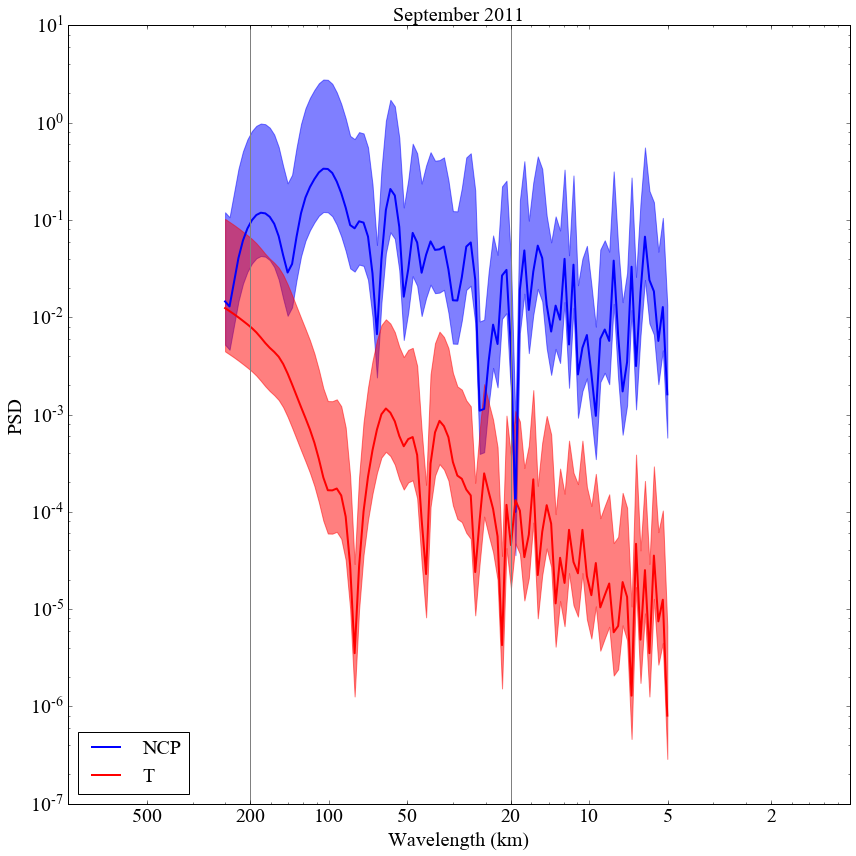

In [5]:
# Lomb-Scargle periodogram

# for Tokyo_3 cruise
N = np.max(Tok3['x'].values) - np.min(Tok3['x'].values)

Tok3['nx'] = Tok3['x'] - np.min(Tok3['x'].values)

for n in range(np.int(N/M)):
    data = Tok3[(Tok3['nx']>n*M) & (Tok3['nx']<M*(n+1))]
    pgram =+ np.abs(lombscargle(data['x'].values, (data['Air-sea flux'].values-data['Air-sea flux'].mean())*np.hanning(len(data)), angular_freqs))
    pgramT =+ np.abs(lombscargle(data['x'].values, (data['T'].values-data['T'].mean())*np.hanning(len(data)), angular_freqs))

pgram = pgram/N
pgramT = pgramT/N

nu = 2*(np.int(N/M))
err_high = nu/ss.chi2.ppf(0.05/2, nu)
err_low = nu/ss.chi2.ppf(1-0.05/2, nu)


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
plt.plot(1/periods, pgram, '-b', lw=2, label = 'NCP')
plt.fill_between(1/periods, pgram*err_low, pgram*err_high, color='blue', alpha = 0.5)

plt.plot(1/periods, pgramT, '-r', lw=2, label='T')
plt.fill_between(1/periods, pgramT*err_low, pgramT*err_high, color='red', alpha = 0.5)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.yscale('log')
plt.xscale('log')

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavelength (km)', fontsize = 20)
plt.xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

plt.axvline(1./200, color = 'grey')
plt.axvline(1./20, color = 'grey')

plt.title('September 2011',fontsize = 20)

print 'number of segments = ',np.int(N/M)

A = np.vstack([np.log10(1./periods), np.ones(len(periods))]).T

#m, c = np.linalg.lstsq(A, np.log10(pgram))[0]
m,c, r, p, std_err = ss.linregress(np.log10(1./periods),np.log10(pgram))

#mT, c = np.linalg.lstsq(A, np.log10(pgramT))[0]
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(1./periods),np.log10(pgramT))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value = ', p
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value = ', pT

#plt.loglog(1./periods, ((1./periods)**mT)/100000000000, 'r')
#plt.loglog(1./periods, ((1./periods)**m)/100000, 'b')
plt.show()

#fig1.savefig('../figures/NCP_T_spectra_Sept11.png', bbox_inches='tight', dpi=600)

number of segments =  2
estimated slope for NCP =  -2.01637057132 , r =  -0.905104081144 , p-value =  3.53763656118e-38
estimated slope for T =  -1.92540263245 , r =  -0.888946643318 , p-value =  5.26036168604e-35


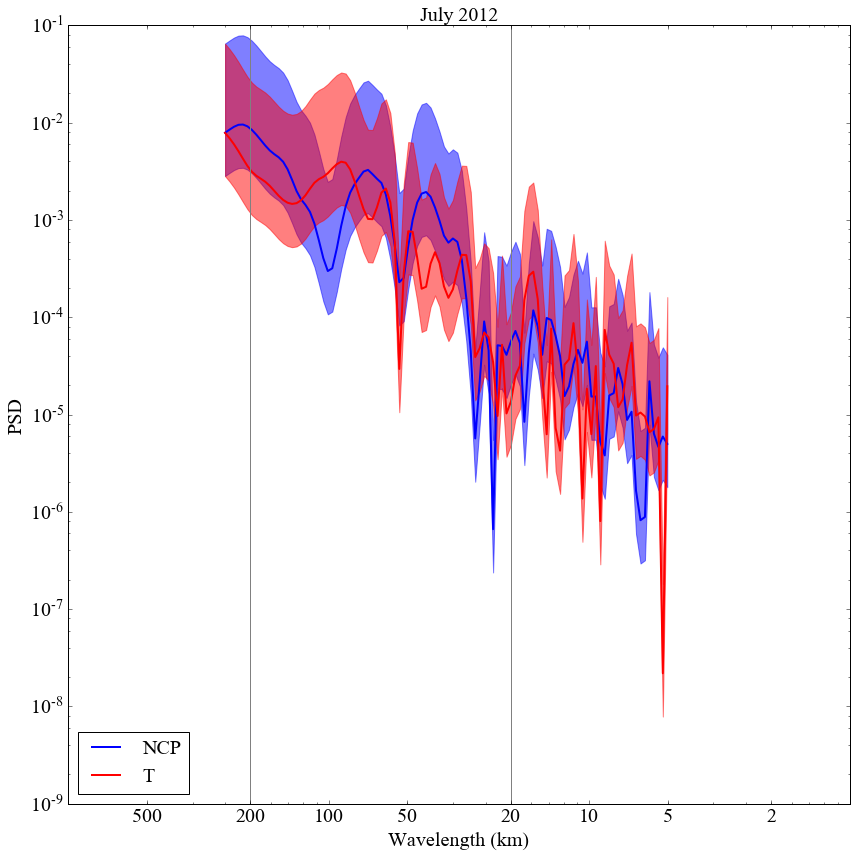

In [6]:
# Lomb-Scargle periodogram

# for Tianjin cruise
N = np.max(Tian['x'].values) - np.min(Tian['x'].values)


Tian['nx'] = Tian['x'] - np.min(Tian['x'].values)

for n in range(np.int(N/M)):
    data = Tian[(Tian['nx']>n*M) & (Tian['nx']<M*(n+1))]
    pgram =+ lombscargle(data['x'].values, (data['Air-sea flux'].values-data['Air-sea flux'].mean())*np.hanning(len(data)), angular_freqs)
    pgramT =+ lombscargle(data['x'].values, (data['T'].values-data['T'].mean())*np.hanning(len(data)), angular_freqs)

pgram = pgram/N
pgramT = pgramT/N

nu = 2*(np.int(N/M))
err_high = nu/ss.chi2.ppf(0.05/2, nu)
err_low = nu/ss.chi2.ppf(1-0.05/2, nu)


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
plt.plot(1/periods, pgram, '-b', lw=2, label = 'NCP')
plt.fill_between(1/periods, pgram*err_low, pgram*err_high, color='blue', alpha = 0.5)

plt.plot(1/periods, pgramT, '-r', lw=2, label = 'T')
plt.fill_between(1/periods, pgramT*err_low, pgramT*err_high, color='red', alpha = 0.5)

plt.yscale('log')
plt.xscale('log')

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavelength (km)', fontsize = 20)
plt.xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

plt.axvline(1./200, color = 'grey')
plt.axvline(1./20, color = 'grey')

plt.title('July 2012',fontsize = 20)

A = np.vstack([np.log10(1./periods), np.ones(len(periods))]).T

print 'number of segments = ',np.int(N/M)
#m, c = np.linalg.lstsq(A, np.log10(pgram))[0]
m,c, r, p, std_err = ss.linregress(np.log10(1./periods),np.log10(pgram))

#mT, c = np.linalg.lstsq(A, np.log10(pgramT))[0]
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(1./periods),np.log10(pgramT))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value = ', p
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value = ', pT

#plt.loglog(1./periods, ((1./periods)**mT)/10000000000000, 'r')
#plt.loglog(1./periods, ((1./periods)**m)/10000000000, 'b')
plt.show()

#fig1.savefig('../figures/NCP_T_spectra_July12.png', bbox_inches='tight', dpi=600)